# EKF for Differential Drive Vehicle: (Assignment1_EKF part)
**Name:** Shahid Ahamed Hasib

This notebook implements the Extended Kalman Filter (EKF) for a nonlinear
multiple input and multiple output (MIMO) system: a differential-drive robot.
It follows the homework description:

- State: planar position, heading, and speed
- Inputs: linear acceleration and angular rate
- High-rate IMU-like measurements of acceleration and angular rate (100 Hz)
- Low-rate noisy position measurements (1 Hz)
- Study of the effect of increasing noise in IMU and in position measurements


## Imports and helper utilities

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

np.set_printoptions(precision=3, suppress=True)
plt.rcParams['figure.figsize'] = (8, 6)


## Differential-drive simulation

In [2]:
@dataclass
class SimulationResult:
    t: np.ndarray
    truth: np.ndarray  # [x, y, theta, v]
    controls: np.ndarray  # [a, omega]
    pos_indices: np.ndarray


def simulate_diff_drive(T=30.0, dt=0.01, pos_dt=1.0):
    t = np.arange(0, T + dt, dt)
    n = len(t)
    x = np.zeros((n, 4))
    x[0] = [0.0, 0.0, 0.0, 0.5]
    u = np.zeros((n, 2))
    for k, tk in enumerate(t):
        u[k, 0] = 0.4 * np.cos(0.35 * tk)  # linear acceleration
        u[k, 1] = 0.2 * np.sin(0.25 * tk) + 0.05  # yaw rate
        if k == 0:
            continue
        x_prev = x[k - 1].copy()
        a, omega = u[k - 1]
        theta = x_prev[2] + omega * dt
        v = x_prev[3] + a * dt
        x[k, 0] = x_prev[0] + v * np.cos(theta) * dt
        x[k, 1] = x_prev[1] + v * np.sin(theta) * dt
        x[k, 2] = theta
        x[k, 3] = v
    pos_inds = np.arange(0, n, int(pos_dt / dt))
    return SimulationResult(t, x, u, pos_inds)


## Measurement generation

In [3]:
def generate_measurements(sim: SimulationResult, a_std=0.2, omega_std=0.02, pos_noise_std=0.5):
    noisy_u = sim.controls.copy()
    noisy_u[:, 0] += np.random.normal(0, a_std, size=len(sim.t))
    noisy_u[:, 1] += np.random.normal(0, omega_std, size=len(sim.t))

    pos_meas = np.full((len(sim.t), 2), np.nan)
    pos_noise = np.random.normal(0, pos_noise_std, size=(len(sim.pos_indices), 2))
    pos_meas[sim.pos_indices] = sim.truth[sim.pos_indices, :2] + pos_noise
    return noisy_u, pos_meas


## EKF implementation

## System model and simulation

I have considered the state vector
$$
x = \begin{bmatrix} p_x \\ p_y \\ \theta \\ v \end{bmatrix},
$$
where $p_x, p_y$ are the robot's planar position, $\theta$ is the heading,
and $v$ is the forward speed. The input vector is
$$
u = \begin{bmatrix} a \\ \omega \end{bmatrix},
$$
with linear acceleration $a$ and angular rate $\omega$.

Using a simple discrete-time integration with sampling time $dt$,
$$
\begin{aligned}
p_x^{+} &= p_x + v \cos\theta \, dt,\\
p_y^{+} &= p_y + v \sin\theta \, dt,\\
\theta^{+} &= \theta + \omega \, dt,\\
v^{+} &= v + a \, dt.
\end{aligned}
$$

The function below simulates a ground-truth trajectory and the corresponding
control inputs for a fixed time horizon.


In [4]:
def process_model(x, u, dt):
    px, py, theta, v = x
    a, omega = u
    theta_new = theta + omega * dt
    v_new = v + a * dt
    px_new = px + v_new * np.cos(theta_new) * dt
    py_new = py + v_new * np.sin(theta_new) * dt
    return np.array([px_new, py_new, theta_new, v_new])


def jacobian_F(x, u, dt):
    a, omega = u
    theta = x[2] + omega * dt
    v = x[3] + a * dt
    F = np.eye(4)
    F[0, 2] = -v * np.sin(theta) * dt
    F[0, 3] = np.cos(theta) * dt
    F[1, 2] = v * np.cos(theta) * dt
    F[1, 3] = np.sin(theta) * dt
    return F


def process_noise(a_std, omega_std, dt):
    q_pos = (0.5 * dt ** 2 * a_std) ** 2
    q_theta = (dt * omega_std) ** 2
    q_v = (dt * a_std) ** 2
    return np.diag([q_pos, q_pos, q_theta, q_v])


def ekf_filter(sim: SimulationResult, u_meas, pos_meas, a_std, omega_std, pos_noise_std, P0=None):
    dt = np.mean(np.diff(sim.t))
    H = np.array([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
    R = np.diag([pos_noise_std ** 2, pos_noise_std ** 2])
    x = np.array([0.0, 0.0, 0.0, 0.5])
    P = P0 if P0 is not None else np.diag([1, 1, 0.2, 1])

    est = np.zeros_like(sim.truth)
    for k, tk in enumerate(sim.t):
        x_pred = process_model(x, u_meas[k], dt)
        F = jacobian_F(x, u_meas[k], dt)
        Q = process_noise(a_std, omega_std, dt)
        P = F @ P @ F.T + Q
        x = x_pred

        if not np.isnan(pos_meas[k, 0]):
            z = pos_meas[k]
            y = z - x[:2]
            S = H @ P @ H.T + R
            K = P @ H.T @ np.linalg.inv(S)
            x = x + K @ y
            P = (np.eye(4) - K @ H) @ P
        est[k] = x
    return est


## Extended Kalman Filter (EKF)

The EKF prediction step uses the nonlinear process model $f(x_k, u_k)$
and its Jacobian $F_k = \frac{\partial f}{\partial x}\big|_{x_k}$.
Process noise is modeled as zero-mean Gaussian and mapped through a
matrix $Q_k$.

The update step uses a linear measurement model
$$
z_k = H x_k + v_k, \quad
H =
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0
\end{bmatrix},
$$
with measurement noise covariance $R$.

The function below implements a standard EKF loop:

- propagate state and covariance using the IMU data (100 Hz),
- update with position measurements when available (1 Hz).


## Utility functions

## Baseline EKF performance

We first run the EKF with nominal noise levels:

- acceleration noise standard deviation: $\sigma_a = 0.3$
- angular-rate noise standard deviation: $\sigma_\omega = 0.02$
- position noise standard deviation: $\sigma_p = 0.5$

The plots below show the true trajectory and the EKF estimate, as well as
the root-mean-square (RMS) position error over the whole run.


In [ ]:
def rmse(truth, est):
    return np.sqrt(np.mean((truth - est) ** 2, axis=0))

def plot_trajectory(sim, est, title="Baseline EKF trajectory"):
    plt.figure()

    # Truth and EKF estimate
    plt.plot(sim.truth[:, 0], sim.truth[:, 1], label="Truth")
    plt.plot(est[:, 0], est[:, 1], label="EKF Estimate")

    # Position measurements
    idx = sim.pos_indices                          
    plt.scatter(sim.truth[idx, 0],
                sim.truth[idx, 1],
                marker="x", s=40,
                color='black', 
                label="Position meas.")
    

    plt.axis("equal")
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


## Baseline scenario

Baseline RMSE [x, y, theta, v]: [0.22  0.313 0.058 0.134]


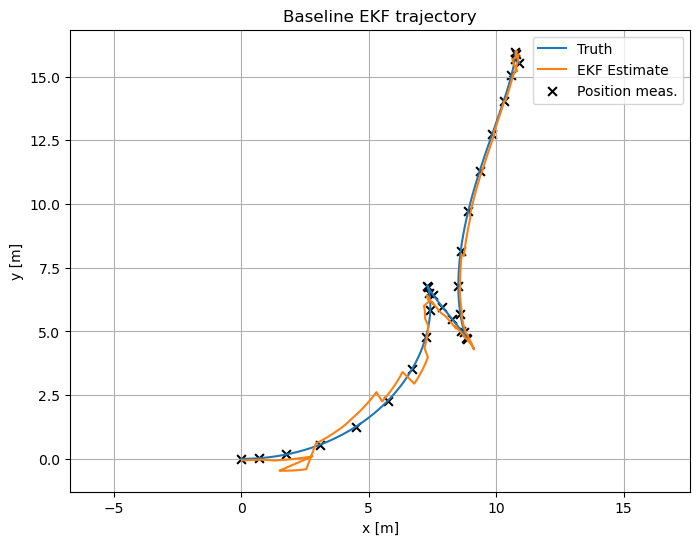

In [6]:
np.random.seed(0)
sim = simulate_diff_drive(T=30.0, dt=0.01, pos_dt=1.0)
a_std, omega_std, pos_std = 0.3, 0.02, 0.5
u_meas, pos_meas = generate_measurements(sim, a_std, omega_std, pos_std)

est_baseline = ekf_filter(sim,
                          u_meas=u_meas,
                          pos_meas=pos_meas,
                          a_std=a_std,
                          omega_std=omega_std,
                          pos_noise_std=pos_std)

print("Baseline RMSE [x, y, theta, v]:", rmse(sim.truth, est_baseline))
plot_trajectory(sim, est_baseline)

### Here, Since sim.truth has the ground-truth states, those “Position meas.” markers sit exactly on the blue truth curve, However if we plot the pos_meas, they are the noisy positionsm they will roughly following the true path, they will be a bit scattered around it (amount depends on pos_std). I just want to show when measurements happen, not their noise. So I have changed the scatter to use the true states instead of pos_meas.

## Noise sensitivity: IMU noise

## Measurement and noise model

I assumed:

- High-rate IMU-like measurements of acceleration and angular rate:
  $$
  \tilde{a}_k = a_k + n_a, \qquad
  \tilde{\omega}_k = \omega_k + n_\omega,
  $$
  with zero-mean Gaussian noise $n_a, n_\omega$.

- Low-rate position measurements available every 1 s:
  $$
  \tilde{z}_k =
  \begin{bmatrix}
  \tilde{p}_x \\ \tilde{p}_y
  \end{bmatrix}
  =
  \begin{bmatrix}
  p_x \\ p_y
  \end{bmatrix}
  +
  n_p,
  $$
  with zero-mean Gaussian noise $n_p$.

The code below generates noisy IMU data at 100 Hz and position
measurements at 1 Hz for the simulated trajectory.


## Effect of increasing noise levels

To study the sensitivity of the EKF, we vary:

1. **IMU noise** (acceleration and angular rate), keeping position noise fixed.
2. **Position noise**, keeping IMU noise fixed.

For each configuration we compute the RMS position error over the trajectory.
This allows us to see how process vs measurement noise affect estimation quality.


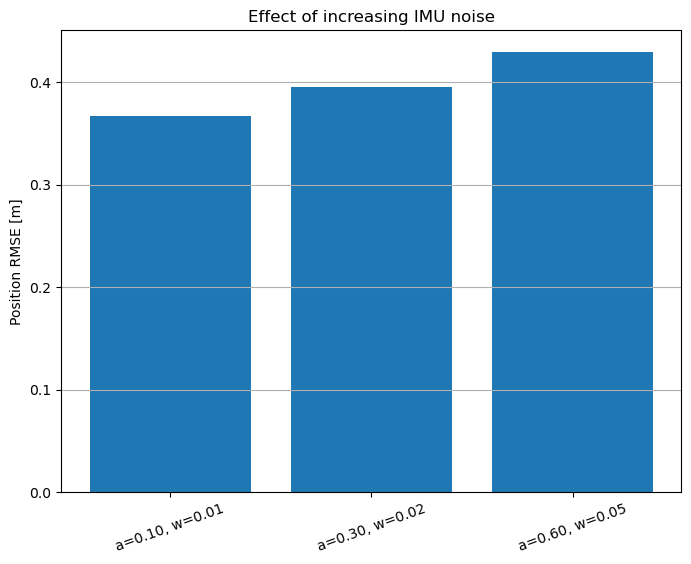

In [7]:
imu_levels = [(0.1, 0.01), (0.3, 0.02), (0.6, 0.05)]
results_imu = []
for a_std_i, omega_std_i in imu_levels:
    np.random.seed(1)
    u_meas, pos_meas = generate_measurements(sim, a_std_i, omega_std_i, pos_std)
    est = ekf_filter(sim, u_meas, pos_meas, a_std_i, omega_std_i, pos_std)
    results_imu.append((a_std_i, omega_std_i, rmse(sim.truth[:, :2], est[:, :2])))

plt.figure()
labels = [f"a={a:.2f}, w={w:.2f}" for a, w, _ in results_imu]
rmse_vals = [np.linalg.norm(r[:2]) for _, _, r in results_imu]
plt.bar(labels, rmse_vals)
plt.ylabel('Position RMSE [m]')
plt.title('Effect of increasing IMU noise')
plt.xticks(rotation=20)
plt.grid(axis='y')
plt.show()


## Noise sensitivity: position noise

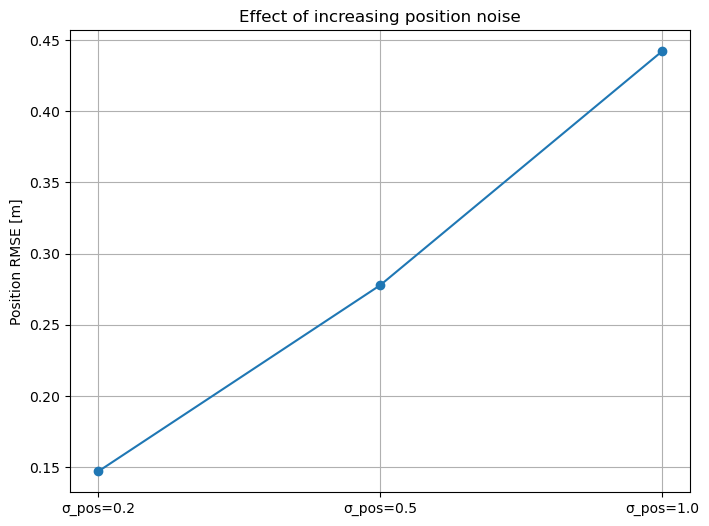

In [8]:
pos_levels = [0.2, 0.5, 1.0]
pos_results = []
for pos_std_i in pos_levels:
    np.random.seed(2)
    u_meas, pos_meas = generate_measurements(sim, a_std, omega_std, pos_std_i)
    est = ekf_filter(sim, u_meas, pos_meas, a_std, omega_std, pos_std_i)
    pos_results.append((pos_std_i, rmse(sim.truth[:, :2], est[:, :2])))

plt.figure()
labels = [f"σ_pos={p:.1f}" for p, _ in pos_results]
rmse_vals = [np.linalg.norm(r[:2]) for _, r in pos_results]
plt.plot(labels, rmse_vals, marker='o')
plt.ylabel('Position RMSE [m]')
plt.title('Effect of increasing position noise')
plt.grid(True)
plt.show()


## Observations

* Higher IMU noise (acceleration and yaw-rate) worsens propagation; the EKF relies more on sparse position fixes, so position RMSE grows.
* Increasing position noise directly weakens the correction step and yields slower drift arrest.
* Because the measurement model is linear in position, the EKF remains stable as long as the noise levels are reflected in Q and R.